**Лабораторная работа 1.** Графы видимости

### 0. Скачивание необходимых библиотек

In [1]:
# %pip uninstall igraph -y
# %pip uninstall python-igraph -y
# %pip install python-igraph==0.9.6
# %pip install cairocffi # Рендер графиков
# %pip install apimoex # API Московской биржи
# %pip install pycairo # Рендер графиков
# %pip install igraph 
# %pip install ts2vg # Visibility graphs
# %pip install networkx
#%pip install --user --upgrade scipy

### 1. С использованием API (например, apimoex, yfinance) загрузите исходные данные - котировки акций из индекса Московской биржи (период - 1 день) за последний год.

In [68]:
import requests
import numpy as np
import pandas as pd
import apimoex
import matplotlib.pyplot as plt
import igraph as ig
import networkx as nx


In [112]:
with requests.Session() as session:
    data = apimoex.get_board_history(session, 'SBER')
    df = pd.DataFrame(data)
    df.set_index('TRADEDATE', inplace=True)
df.head()


,BOARDID,CLOSE,VOLUME,VALUE
TRADEDATE,,,,
2013-03-25,TQBR,98.79,593680,59340002.8
2013-03-26,TQBR,97.20,1283550,126030358.8
2013-03-27,TQBR,96.75,1261950,121835900.2
2013-03-28,TQBR,98.59,1971410,192469794.9
2013-03-29,TQBR,98.76,782000,77268860.1


In [114]:
df.shape
# plt.plot(df['CLOSE'])

(2399, 4)

In [119]:
# Удаление строк без данных и выбросов
n_samples = df['CLOSE'].shape[0]
df['CLOSE'].dropna(inplace=True)

q = 0.95
q_low = df['CLOSE'].quantile(1-q)
q_hi  = df['CLOSE'].quantile(q)

df_filtered = df[(df['CLOSE'] < q_hi) & (df['CLOSE'] > q_low)]
print(f"Было : {n_samples} сэмплов, стало {df_filtered['CLOSE'].shape[0]} сэмплов")
# plt.plot(df_filtered['CLOSE'])

Было : 2333 сэмплов, стало 2099 сэмплов


### 2. Отобразите нормированные логарифмические доходности SBER в граф видимости: обычный и горизонтальный (igraph, NetworkX).


In [120]:
df=df_filtered
returns = (df['CLOSE'] - df['CLOSE'].shift(-1)) / df['CLOSE'].shift(-1)
import sys
norm_returns = (returns - returns.min()) / (returns.max() - returns.min())

print(norm_returns.max())
print(norm_returns.min())
print(norm_returns.shape)

#plt.plot(norm_returns)
#plt.show()


1.0
0.0
(2099,)


In [121]:
lognorm_returns = np.log(norm_returns)

#lognorm_returns.replace(-np.inf, lognorm_returns.replace(-np.inf, 0, inplace=False).min(), inplace=True)
lognorm_returns.replace([-np.inf, np.inf], np.nan, inplace=True)

lognorm_returns.dropna(inplace=True)

print(lognorm_returns.max())
print(lognorm_returns.min())
print(lognorm_returns.shape)
# plt.plot(lognorm_returns)
# plt.show()

0.0
-3.180264895332978
(2097,)


c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [122]:
import pickle
file = open("returns_SBER_3.pickle", 'wb')
pickle.dump(lognorm_returns, file)
file.close()

In [ ]:
file = open("returns_SBER.pickle", 'rb')
lognorm_returns=pickle.load(file)
file.close()

Граф видимости (обычный)

<AxesSubplot:>

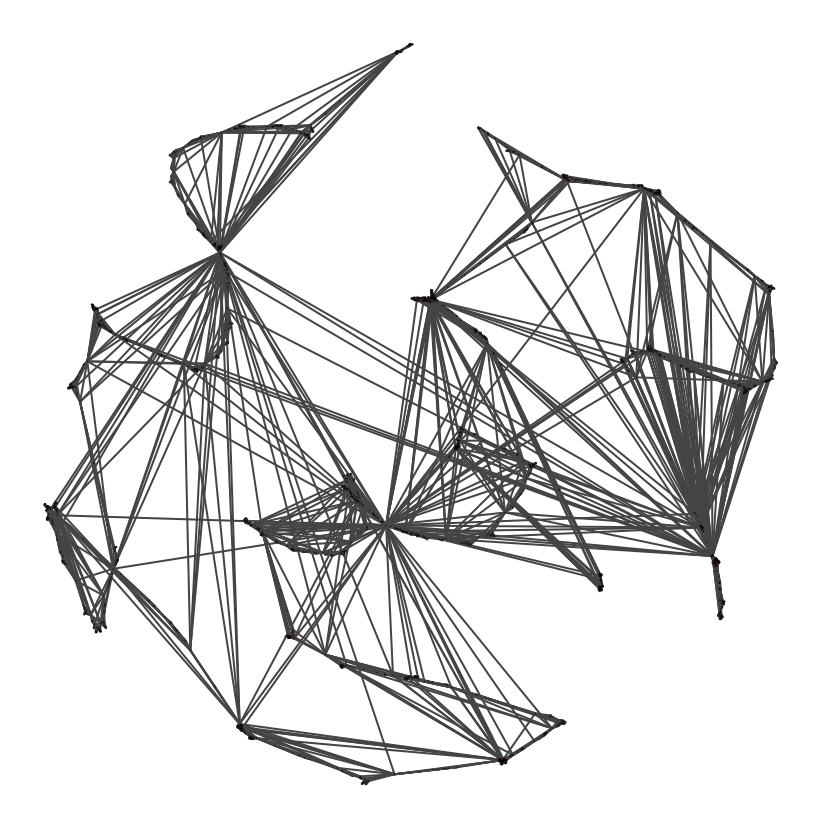

In [7]:
from ts2vg import NaturalVG
g = NaturalVG()
g.build(lognorm_returns)
igraph_g=g.as_igraph()


edges = g.edges

fig, ax = plt.subplots(figsize=(15,15))
ig.plot(igraph_g, 
    target=ax)

Граф видимости: горизонтальный 

<AxesSubplot:>

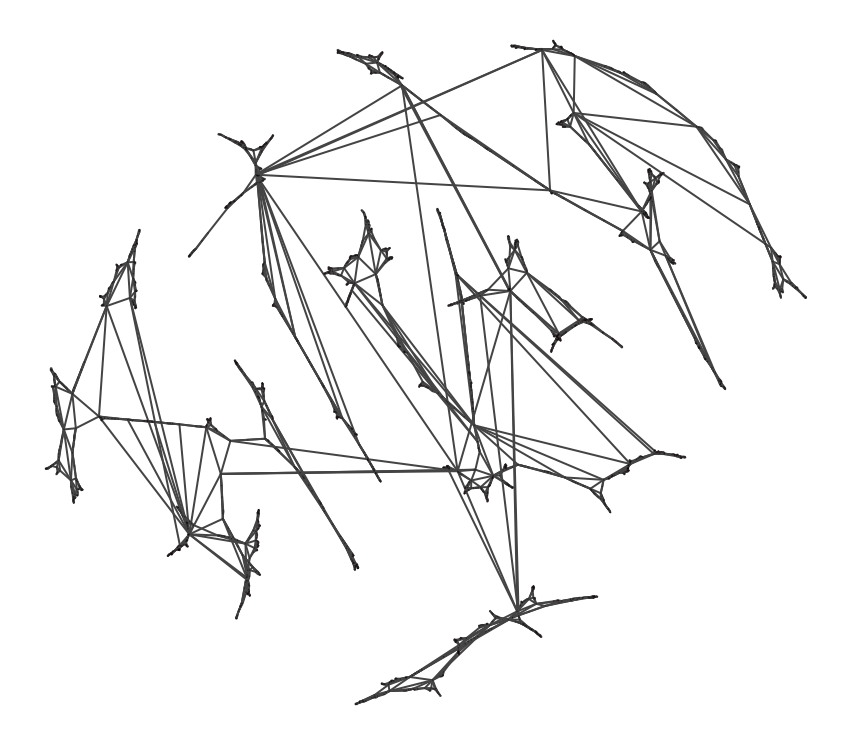

In [8]:
from ts2vg import HorizontalVG
g = HorizontalVG()
g.build(lognorm_returns)
igraph_g=g.as_igraph()

edges = g.edges

fig, ax = plt.subplots(figsize=(15,15))
ig.plot(igraph_g, 
    target=ax)

### 3. Отобразите нормированные логарифмические доходности SBER, GAZP, GMKN в граф видимости: обычный и горизонтальный

In [139]:
def get_data(tick):
    with requests.Session() as session:
        data = apimoex.get_board_history(session, tick)
        df = pd.DataFrame(data)
        df.set_index('TRADEDATE', inplace=True)

    q = 0.99
    q_low = df['CLOSE'].quantile(1-q)
    q_hi  = df['CLOSE'].quantile(q)
    df.dropna(inplace=True)
    df = df[(df['CLOSE'] < q_hi) & (df['CLOSE'] > q_low)]
    returns = (df['CLOSE'] - df['CLOSE'].shift(-1)) / df['CLOSE'].shift(-1)
    import sys
    norm_returns = (returns - returns.min()) / (returns.max() - returns.min())
    lognorm_returns = np.log(norm_returns)
    lognorm_returns.replace([-np.inf, np.inf], np.nan, inplace=True)
    lognorm_returns.dropna(inplace=True)
    return lognorm_returns

def plot_graphs_norm_horiz(ts : np.array, title = None):
    g = NaturalVG(directed=None).build(ts)
    nxg = g.as_networkx()

    # 3. Make plots
    fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, figsize=(12, 3.5))

    if title is not None:
        plt.suptitle(title, verticalalignment='top', fontweight='bold')

    ax0.plot(ts)
    ax0.set_title('Time Series')

    graph_plot_options = {
        'with_labels': False,
        'node_size': 2,
        'node_color': [(0, 0, 0, 1)],
        'edge_color': [(0, 0, 0, 0.15)],
    }

    nx.draw_networkx(nxg, ax=ax1, pos=g.node_positions(), **graph_plot_options)
    ax1.tick_params(bottom=True, labelbottom=True)
    ax1.plot(ts)
    ax1.set_title('Visibility Graph')

    nx.draw_networkx(nxg, ax=ax2, pos=nx.kamada_kawai_layout(nxg), **graph_plot_options)
    ax2.set_title('Visibility Graph')


In [140]:
tickers = ['SBER', 'GAZP', 'GMKN']

In [141]:
returns = {}

for ticker in tickers:
    cur_returns = get_data(ticker)
    returns[ticker] = cur_returns

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [142]:
file = open("returns_SBER_GAZP_GMKN.pickle", 'wb')
pickle.dump(returns, file)
file.close()

In [12]:
start_day = 1344
year = 253

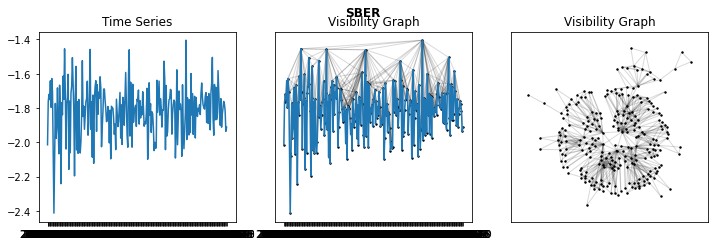

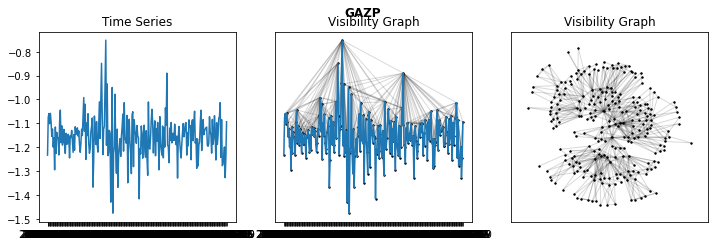

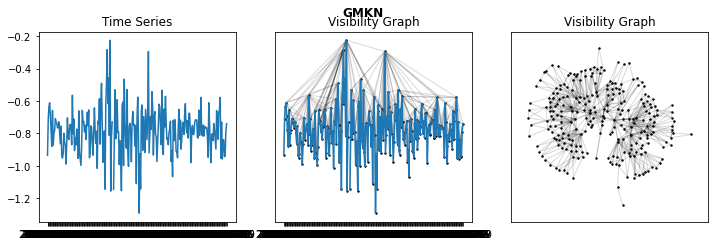

In [13]:
for ticker in tickers: 
    plot_graphs_norm_horiz(returns[ticker][start_day:start_day+year], ticker)

### 4. Вычислите и сравните для полученных графов следующие характеристики: диаметр, радиус, центр, периферийные вершины, плотность, локальный и глобальный коэффициент кластеризации (транзитивность), спектр, среднюю степень вершин. 

### 6. Найдите точки сочленения и мосты.

In [14]:
df_characteristics = pd.DataFrame(index = tickers, 
    columns = ['диаметр', 'радиус', 'плотность',
    'транзитивность', 'спектр', 'средняя степень вершин'])

In [15]:
def find_mean_degree(graph : ig.Graph):
    return np.mean(list(graph.degree_distribution()))

In [29]:
for ticker in tickers:
    g = NaturalVG(directed=None).build(returns[ticker])
    g_networkx = g.as_networkx()
    g_igraph = g.as_igraph()
    df_characteristics.loc[ticker, 'диаметр'] = g_igraph.diameter()
    df_characteristics.loc[ticker, 'радиус'] = g_igraph.radius()
    df_characteristics.loc[ticker, 'плотность'] =  g_igraph.density()
    df_characteristics.loc[ticker, 'транзитивность'] = nx.transitivity(g_networkx)
    #df_characteristics.loc[ticker, 'спектр'] = nx.spectrum.adjacency_spectrum(g_networkx)
    df_characteristics.loc[ticker, 'средняя степень вершин'] = np.mean(list(g_igraph.degree()))
    
    print(f'Для графа видимости {ticker} :')
    print(f'Центр : {nx.center(g_networkx)}')
    print(f'Периферийные вершины : {nx.periphery(g_networkx)}')
    print(f'Мосты : {list(nx.bridges(g_networkx))}')
    print(f'Сочленения : {list(nx.articulation_points(g_networkx))}\n')

Для графа видимости для SBER :

Центр : [2199, 2197, 1241, 358, 330, 305, 273, 241, 235]
Периферийные вершины : [12, 10, 9, 8, 3, 5, 6, 7, 2, 774, 693, 752, 768, 979, 732, 731, 734, 777, 527, 528, 529, 557, 736, 1775, 1803, 472, 514, 515, 517, 533, 535, 536, 537, 538, 554, 548, 556, 728, 959, 1010, 1773, 451, 450, 520, 531, 549, 550, 741, 907, 567, 566, 738, 739, 909, 1626, 1625, 1624, 1629, 1630, 1631, 1490, 1589, 1590, 1622, 1633, 1824, 1825, 1826, 1353, 1881, 591, 595, 606, 1603, 1668, 1676, 588, 891, 840, 1475]
Мосты : [(2331, 2332)]
Сочленения : [14, 40, 235, 2331, 2328, 2199]
Для графа видимости для GAZP :

Центр : [1969, 1902, 1426, 1264, 1012, 941, 527, 400, 241]
Периферийные вершины : [2035, 30, 134, 148, 36, 151, 309, 313, 34, 202, 70, 74, 312, 1106, 1152, 58, 68, 76, 78, 54, 53, 59, 61, 73, 352, 896, 47, 46, 52, 1140, 42, 726, 44, 724, 102, 101, 48, 807, 837, 861, 862, 879, 796, 880, 877]
Мосты : [(2033, 2034), (2034, 2035)]
Сочленения : [2, 9, 2034, 2033, 2031, 1969]
Для гр

In [35]:
df_characteristics.loc[:, df_characteristics.columns != 'спектр']
df_characteristics.loc[:, df_characteristics.columns != 'спектр'].apply(pd.to_numeric).style.background_gradient(cmap='Blues')

,диаметр,радиус,плотность,транзитивность,средняя степень вершин
SBER,9,5,0.002680,0.308566,6.247856
GAZP,9,5,0.003105,0.314694,6.315479
GMKN,10,5,0.003107,0.329922,6.320393


In [78]:
import pickle
file = open("characteristics_SBER_GAZP_GMKN.pickle", 'wb')
pickle.dump(df_characteristics, file)
file.close()

### 5. Постройте эмпирическую диаграмму распределения степеней вершин, выберите закон распределения степеней вершин и оцените его параметры, оцените качество подгонки статистически.

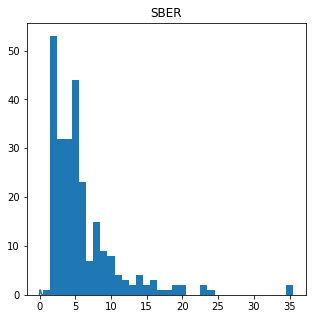

In [132]:

start_day = 1344
year = 253
cur_ticker = 'SBER'

g = NaturalVG(directed=None).build(returns[cur_ticker][start_day:start_day+year])
nxg = g.as_networkx()
g_igraph = g.as_igraph()

hist_tuples=list(g_igraph.degree_distribution().bins()) 

fig, ax = plt.subplots(figsize=(5,5))

ax.set_title(cur_ticker)
ax.bar(x = [x[0] for x in hist_tuples], 
        height = [x[2] for x in hist_tuples],
        width = [x[1] - x[0] for x in hist_tuples])
ax.plot(x, PDF)
plt.show()

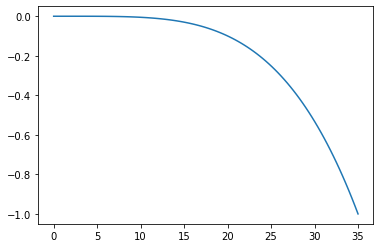

In [137]:
alpha=2
beta=4

def eval_beta_distribution_PDF(x, a, b):
    result = np.power(x, a - 1) * np.power(1 - x, b - 1)
    result = result/np.abs((np.max(result) - np.min(result)))
    return result

x = np.linspace(0, len(hist_tuples), num = 100)
PDF = eval_beta_distribution_PDF(x, alpha, beta)
plt.plot(x, PDF)


Замечания:

Плоский граф видимости

Тест Колмогорова Смирнова 2 распр принадлежат одному классу 

Наложить на один график

### Sandbox. 
Просто полезные куски кода

<AxesSubplot:>

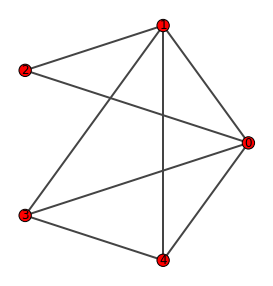

In [54]:
import igraph as ig

n_vertices = 3
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (3, 4)]
g = ig.Graph(n_vertices, edges)

fig, ax = plt.subplots(figsize=(5,5))
ig.plot(
    g,
    target=ax,
    layout="circle", # print nodes in a circular layout
    vertex_size=0.1, 
    vertex_label=range(len(g.vs))
)

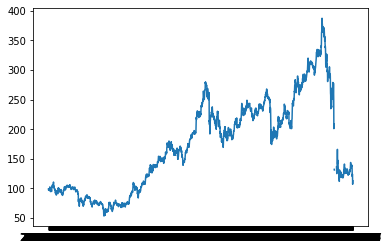

In [64]:
plt.plot(df['CLOSE'])

Text(0.5, 1.0, 'Visibility Graph')

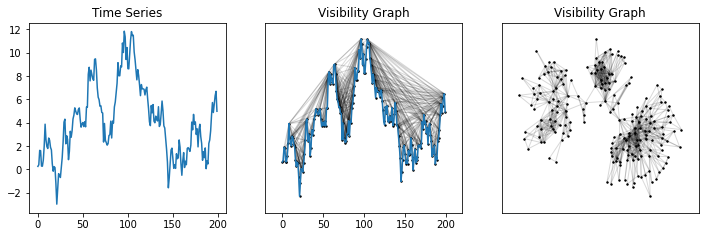

In [63]:
from ts2vg import NaturalVG
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate Brownian motion series
rng = np.random.default_rng(110)
ts = rng.standard_normal(size=200)
ts = np.cumsum(ts)

# 2. Build visibility graph
g = NaturalVG(directed=None).build(ts)
nxg = g.as_networkx()

# 3. Make plots
fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, figsize=(12, 3.5))

ax0.plot(ts)
ax0.set_title('Time Series')

graph_plot_options = {
    'with_labels': False,
    'node_size': 2,
    'node_color': [(0, 0, 0, 1)],
    'edge_color': [(0, 0, 0, 0.15)],
}

nx.draw_networkx(nxg, ax=ax1, pos=g.node_positions(), **graph_plot_options)
ax1.tick_params(bottom=True, labelbottom=True)
ax1.plot(ts)
ax1.set_title('Visibility Graph')

nx.draw_networkx(nxg, ax=ax2, pos=nx.kamada_kawai_layout(nxg), **graph_plot_options)
ax2.set_title('Visibility Graph')
